In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import inspect

summer_concentrations = np.array([0.037, 0.034, 0.018, 0.042, 0.049, 0.022, 0.014, 
0.016, 0.016, 0.048, 0.008, 0.012, 0.034, 0.064, 0.019, 0.043, 0.038, 0.042, 0.048, 0.053, 0.031, 0.030])
up_summer = np.array([0.037, 0.034, 0.018, 0.014, 0.016, 0.016, 0.034, 0.064, 0.019, 0.048, 0.053])
down_summer = np.array([0.042, 0.049, 0.022, 0.048, 0.008, 0.012, 0.043, 0.038, 0.042, 0.031, 0.030])

spring_concentrations = np.array([0.022, 0.028, 0.046, 0.033, 0.024, 0.048, 0.058, 0.038, 0.048, 0.011, 0.031]) 
up_spring = np.array([0.022, 0.028, 0.048, 0.058, 0.038])
down_spring = np.array([0.046, 0.033, 0.024, 0.048, 0.011, 0.031])

Significance

In [36]:
def significant_average(data, hypothesized_mean=0, pvalue=0.05):
    """
    Analyzes carbon concentrations and returns a DataFrame with average, t-statistic, p-value, and significance.

    Parameters:
    data (array-like): Array of concentration values.
    hypothesized_mean (float): Hypothesized mean for the t-test. Default is 0.

    Returns:
    pd.DataFrame: DataFrame with columns 'data_name', 'average', 't_stat', 'p_value', and 'significant'.
    """
    # Calculate the mean
    mean_concentration = np.mean(data)
    # Perform a one-sample t-test
    t_stat, p_value = stats.ttest_1samp(data, hypothesized_mean)
    # Determine if the result is significant
    significant = 'Yes' if p_value < pvalue else 'No'
    # Get the variable name of the data
    frame = inspect.currentframe().f_back
    data_name = [name for name, value in frame.f_locals.items() if value is data][0]
    # Create a DataFrame
    df = pd.DataFrame({
        'data_name': [data_name],
        'average': [mean_concentration],
        't_stat': [t_stat],
        'p_value': [p_value],
        'significant': [significant]
    })
    return df


In [47]:
# calculations
summer = significant_average(summer_concentrations)
spring = significant_average(spring_concentrations)
summer_upstream = significant_average(up_summer)
summer_downstream = significant_average(down_summer)
spring_upstream = significant_average(up_spring)
spring_downstream = significant_average(down_spring)
# concatenate all dataframes together
averages = pd.concat([summer, spring, summer_upstream, summer_downstream, spring_upstream, spring_downstream])
averages.set_index('data_name', inplace=True)

### Carbon PDFs
Full reach spring vs summer

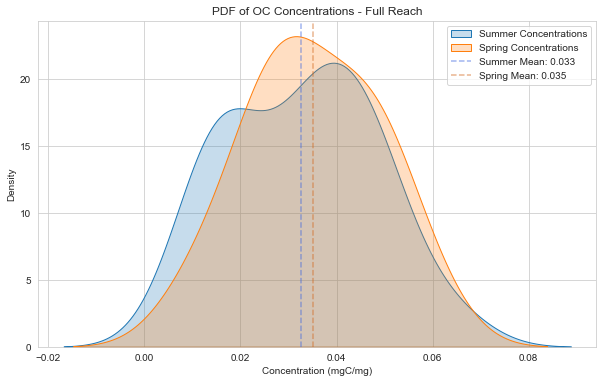

In [52]:
# plotting the PDFs
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.kdeplot(summer_concentrations, label='Summer Concentrations', fill=True)
sns.kdeplot(spring_concentrations, label='Spring Concentrations', fill=True)

# draw vertical lines at the means
plt.axvline(averages.loc['summer_concentrations', 'average'], color='royalblue', linestyle='--', 
            label=f"Summer Mean: {averages.loc['summer_concentrations', 'average']:.3f}", alpha=0.5)
plt.axvline(averages.loc['spring_concentrations', 'average'], color='chocolate', linestyle='--', 
            label=f"Spring Mean: {averages.loc['spring_concentrations', 'average']:.3f}", alpha=0.5)

plt.title('PDF of OC Concentrations - Full Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/seasonal_carbon_PDFs.png', dpi=300)
plt.show()

Upstream spring vs summer

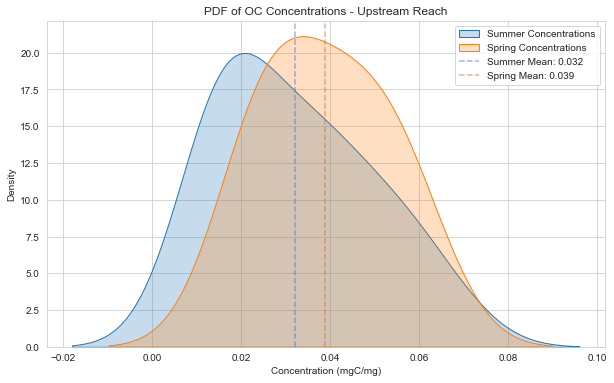

In [53]:
plt.figure(figsize=(10, 6))
sns.kdeplot(up_summer, label='Summer Concentrations', fill=True)
sns.kdeplot(up_spring, label='Spring Concentrations', fill=True)

# draw vertical lines at the means
plt.axvline(averages.loc['up_summer', 'average'], color='royalblue', linestyle='--', 
            label=f"Summer Mean: {averages.loc['up_summer', 'average']:.3f}", alpha=0.5)
plt.axvline(averages.loc['up_spring', 'average'], color='chocolate', linestyle='--', 
            label=f"Spring Mean: {averages.loc['up_spring', 'average']:.3f}", alpha=0.5)

plt.title('PDF of OC Concentrations - Upstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/seasonal_carbon_PDFs_upstream.png', dpi=300)
plt.show()

Downstream spring vs summer

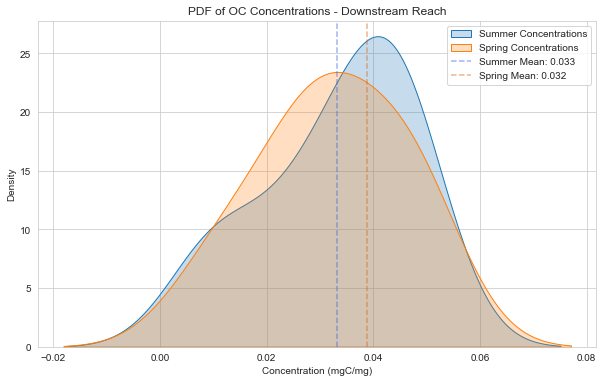

In [55]:
plt.figure(figsize=(10, 6))
sns.kdeplot(down_summer, label='Summer Concentrations', fill=True)
sns.kdeplot(down_spring, label='Spring Concentrations', fill=True)

# draw vertical lines at the means
plt.axvline(averages.loc['down_summer', 'average'], color='royalblue', linestyle='--', 
            label=f"Summer Mean: {averages.loc['down_summer', 'average']:.3f}", alpha=0.5)
plt.axvline(averages.loc['up_spring', 'average'], color='chocolate', linestyle='--', 
            label=f"Spring Mean: {averages.loc['down_spring', 'average']:.3f}", alpha=0.5)

plt.title('PDF of OC Concentrations - Downstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/seasonal_carbon_PDFs_downstream.png', dpi=300)
plt.show()

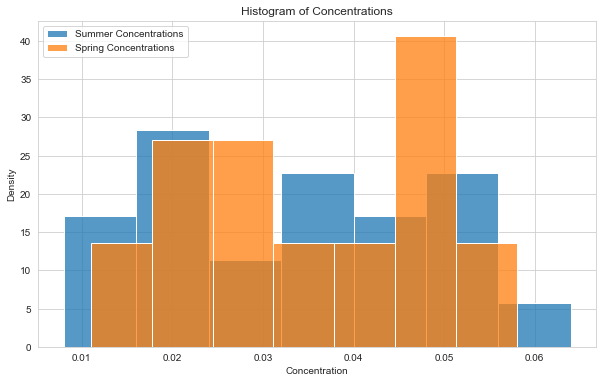

In [67]:
# Plot histogram
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(summer_concentrations, bins=7, stat='density', label='Summer Concentrations', fill=True)
sns.histplot(spring_concentrations, bins=7, stat='density', label='Spring Concentrations', fill=True)
plt.title('Histogram of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

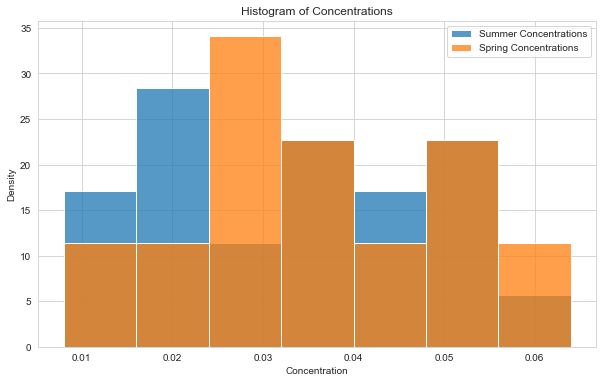

In [76]:
# Calculate the bin edges
min_concentration = min(summer_concentrations.min(), spring_concentrations.min())
max_concentration = max(summer_concentrations.max(), spring_concentrations.max())
bins = np.linspace(min_concentration, max_concentration, 8)  # 7 bins means 8 edges

# Plot histogram
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(summer_concentrations, bins=bins, stat='density', label='Summer Concentrations', fill=True)
sns.histplot(spring_concentrations, bins=bins, stat='density', label='Spring Concentrations', fill=True)
plt.title('Histogram of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

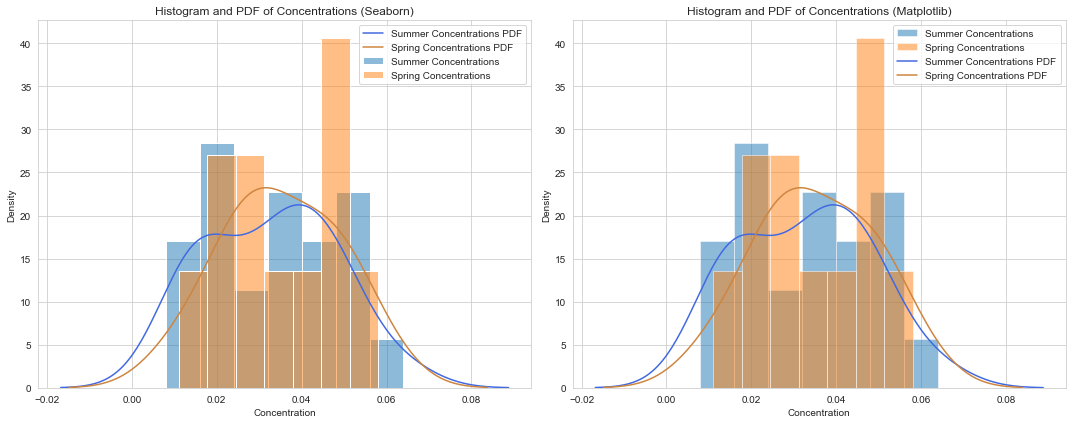

In [68]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram and PDF using sns.histplot and sns.kdeplot
sns.set_style('whitegrid')
sns.histplot(summer_concentrations, bins=7, stat='density', label='Summer Concentrations', fill=True, alpha=0.5, ax=axes[0])
sns.histplot(spring_concentrations, bins=7, stat='density', label='Spring Concentrations', fill=True, alpha=0.5, ax=axes[0])
sns.kdeplot(summer_concentrations, label='Summer Concentrations PDF', fill=False, color='royalblue', ax=axes[0])
sns.kdeplot(spring_concentrations, label='Spring Concentrations PDF', fill=False, color='peru', ax=axes[0])
axes[0].set_title('Histogram and PDF of Concentrations (Seaborn)')
axes[0].set_xlabel('Concentration')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot histogram and PDF using plt.hist and plt.plot
axes[1].hist(summer_concentrations, bins=7, density=True, alpha=0.5, label='Summer Concentrations')
axes[1].hist(spring_concentrations, bins=7, density=True, alpha=0.5, label='Spring Concentrations')
sns.kdeplot(summer_concentrations, label='Summer Concentrations PDF', fill=False, color='royalblue', ax=axes[1])
sns.kdeplot(spring_concentrations, label='Spring Concentrations PDF', fill=False, color='peru', ax=axes[1])
axes[1].set_title('Histogram and PDF of Concentrations (Matplotlib)')
axes[1].set_xlabel('Concentration')
axes[1].set_ylabel('Density')
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

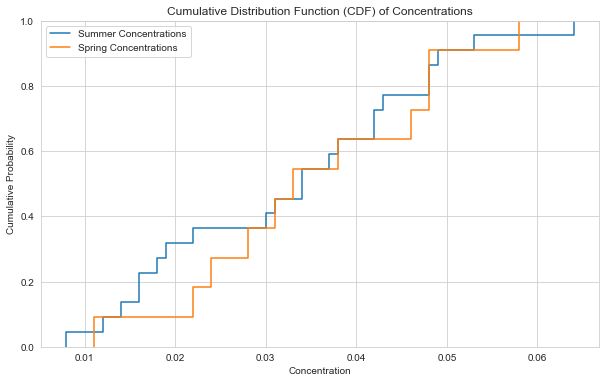

In [69]:
# Plotting the CDFs
plt.figure(figsize=(10, 6))
sns.ecdfplot(summer_concentrations, label='Summer Concentrations')
sns.ecdfplot(spring_concentrations, label='Spring Concentrations')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

## Hecho a mano

In [70]:
# Calculate PDF for summer concentrations
hist_summer, bins_summer = np.histogram(summer_concentrations, bins=10000, density=True)
pdf_summer = hist_summer / sum(hist_summer)
# Calculate PDF for spring concentrations
hist_spring, bins_spring = np.histogram(spring_concentrations, bins=10000, density=True)
pdf_spring = hist_spring / sum(hist_spring)

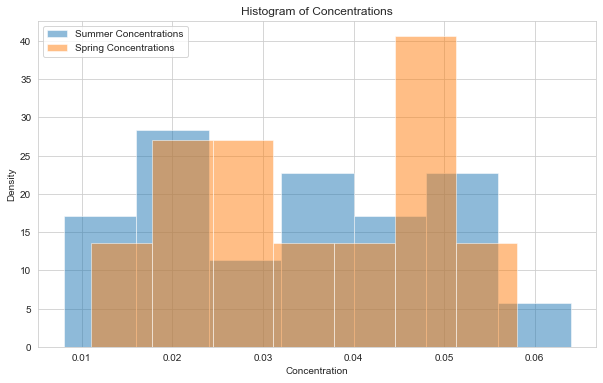

In [71]:
# Plotting the PDFs
plt.figure(figsize=(10, 6))
plt.hist(summer_concentrations, bins=7, density=True, alpha=0.5, label='Summer Concentrations')
plt.hist(spring_concentrations, bins=7, density=True, alpha=0.5, label='Spring Concentrations')
plt.title('Histogram of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

In [72]:
# Calculate CDF for summer concentrations
sorted_summer = np.sort(summer_concentrations)
cdf_summer = np.cumsum(sorted_summer) / np.sum(sorted_summer)

# Calculate CDF for spring concentrations
sorted_spring = np.sort(spring_concentrations)
cdf_spring = np.cumsum(sorted_spring) / np.sum(sorted_spring)

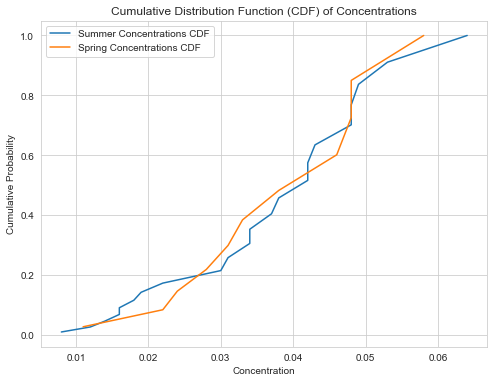

In [73]:
# Plotting the CDFs
plt.figure(figsize=(8, 6))
plt.plot(sorted_summer, cdf_summer, label='Summer Concentrations CDF')
plt.plot(sorted_spring, cdf_spring, label='Spring Concentrations CDF')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

In [ ]:
# Calculate the bin edges
min_concentration = min(summer_concentrations.min(), spring_concentrations.min())
max_concentration = max(summer_concentrations.max(), spring_concentrations.max())
bins = np.linspace(min_concentration, max_concentration, 100)  # 100 bins for example

# Calculate CDF for summer concentrations
hist_summer, bin_edges = np.histogram(summer_concentrations, bins=bins, density=True)
cdf_summer = np.cumsum(hist_summer) * np.diff(bin_edges)

# Calculate CDF for spring concentrations
hist_spring, _ = np.histogram(spring_concentrations, bins=bins, density=True)
cdf_spring = np.cumsum(hist_spring) * np.diff(bin_edges)

# Plotting the CDFs
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[1:], cdf_summer, label='Summer Concentrations CDF')
plt.plot(bin_edges[1:], cdf_spring, label='Spring Concentrations CDF')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

#### Como lo hace el sebs

In [74]:
# Calculate CDF for summer concentrations
summer_cdf = np.cumsum(pdf_summer)
# Calculate CDF for spring concentrations
spring_cdf = np.cumsum(pdf_spring)

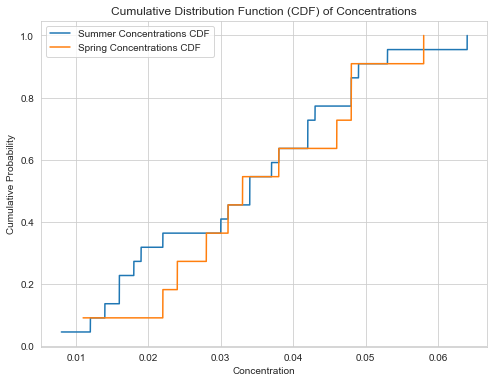

In [78]:
# Plotting the CDFs
plt.figure(figsize=(8, 6))
plt.plot(bins_summer[1:], summer_cdf, label='Summer Concentrations CDF')
plt.plot(bins_spring[1:], spring_cdf, label='Spring Concentrations CDF')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

In [63]:
np.mean(summer_concentrations)

0.02814035087719298

In [64]:
np.mean(spring_concentrations)

0.03518181818181818